# Laboratorio: Programación diferencial

## Objetivos

En esta sesión de laboratorio vamos a poner en práctica todos los conceptos que hemos aprendido sobre la programación cuántica diferencial.

## Descripción

Trabajaremos con dos ejercicios en los que aplicar dicha estrategia:

- La universalidad del computador de puertas establece que podemos construir cualquier función a partir de las puertas disponibles actualmente. En un primer momento se vio que con la puerta Toffoli, la puerta U3 y CNOTs la universalidad quedaba probada, sin embargo, enseguida se comprobó que se podría construir la puerta Toffoli a partir de las otras dos. Nuestro primer objetivo será encontrar la equivalencia a través de estas puertas. 

Importamos Pennylane

In [61]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3, shots=1)

Visualizamos y obtenemos el resultado de una Toffoli ya implementada:

[tensor(1., requires_grad=True),
 tensor(1., requires_grad=True),
 tensor(1., requires_grad=True)]

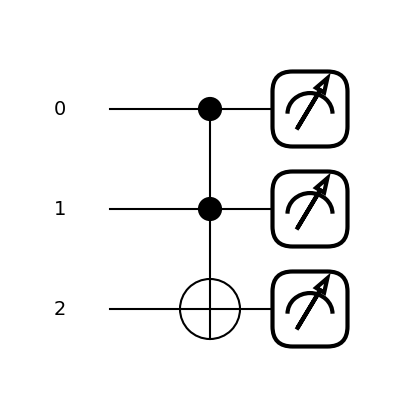

In [62]:
@qml.qnode(dev)
def known_toffoli():
    qml.Toffoli(wires=[0, 1, 2])
    return [qml.expval(qml.PauliZ(wire)) for wire in range(3)]

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(known_toffoli)()

result = known_toffoli()
result

Vemos que si aplicamos dos PauliX a los qubit de control, el qubit objetivo cambia de valor.

[tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True)]

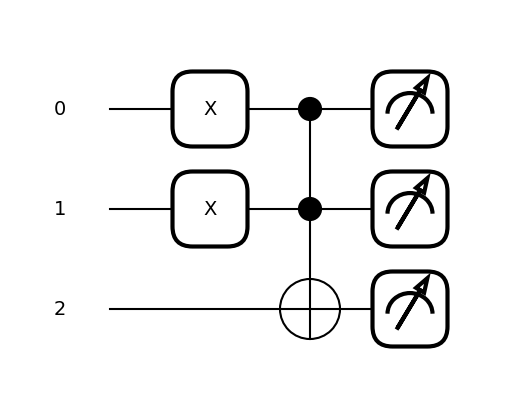

In [63]:
@qml.qnode(dev)
def known_toffoli():
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.Toffoli(wires=[0, 1, 2])
    return [qml.expval(qml.PauliZ(wire)) for wire in range(3)]

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(known_toffoli)()

result = known_toffoli()
result

Nuestro primer objetivo será encontrar la equivalencia a través de estas puertas. No obstante, por facilitar el trabajo, supondremos que ya conocemos algunas de ellas, tal y como podemos ver en la imagen:

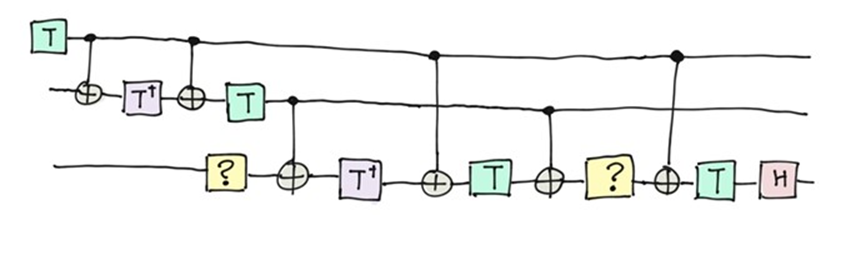

Este ejercicio está afrontado de dos maneras:

- No sabemos qué puertas buscar y buscamos los valores óptimos de U3 para que implemente una Toffoli.
- Sabiendo qué puertas buscamos a priori, buscamos los valores de U3 respectivos a dichas puertas y comprobamos que apliquen correctamente a una Toffoli.

## Buscar parámetros de U3 sin saber las puertas

Defimos el circuito con puertas U3 como incógnita. Los parámetros iniciales serán aleatorios.

In [85]:
params = np.random.rand(6)  # Initialize the parameters

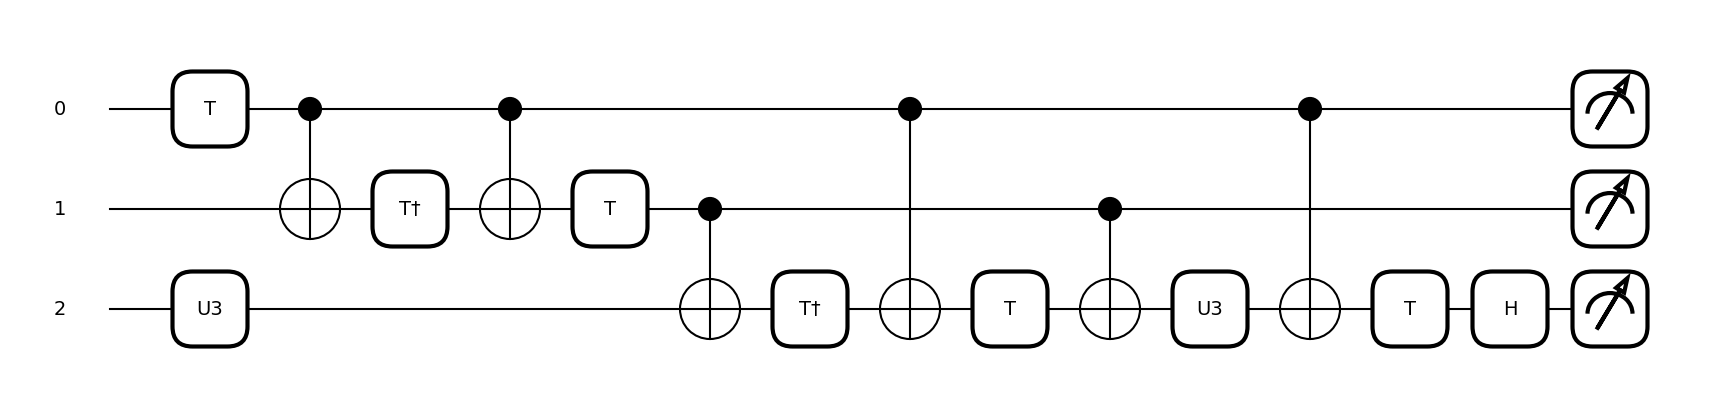

In [87]:
# Define the target operations
@qml.qnode(dev)
def unknown_toffoli(params):
    qml.T(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.adjoint(qml.T(wires=1))
    qml.CNOT(wires=[0, 1])
    qml.T(wires=1)
    qml.U3(params[0], params[1], params[2], wires=2)
    qml.CNOT(wires=[1, 2])
    qml.adjoint(qml.T(wires=2))
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.CNOT(wires=[1, 2])
    qml.U3(params[3], params[4], params[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.Hadamard(wires=2)
    return qml.state()

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(unknown_toffoli)(params)

Definimos la función de coste. Será la fidelidad entre el circuito que ya conocemos de Toffoli y nuestro circuito con parámetros inicialmente aleatorios.

In [ ]:
# Cost function to compare the target operation and parameterized U3 gate
def cost(params, target_state):
    guessed_state = unknown_toffoli(params)
    fidelity = np.abs(np.dot(np.conj(target_state), guessed_state))**2
    return 1 - fidelity

Definimos el optimizador, en este caso el Gradient Descent.

In [ ]:
# Optimizing the parameters for the Hadamard gate
opt = qml.GradientDescentOptimizer(stepsize=0.1)

Ponemos a optimizar los parámetros durante 100 epochs y nos quedamos con los parámetros óptimos para las dos puertas U3.

In [78]:
target_state = known_toffoli()

for i in range(100):
    params, cost_val = opt.step_and_cost(lambda p: cost(p, target_state), params)
    if i % 20 == 0:
        print(f"Step {i}, Cost: {cost_val}")

print("Optimized parameters:", params)

# Store optimized parameters for Hadamard
optimized_params = params

/usr/local/lib/python3.8/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Step 0, Cost: 0.8108945515714712
Step 20, Cost: 0.22855000115663304
Step 40, Cost: 0.013144949516859517
Step 60, Cost: 0.0003263763735578129
Step 80, Cost: 7.507169313747397e-06
Optimized parameters: [ 0.66520134  0.03903012  0.52876195  0.93302111 -0.58055721 -0.37346397]


In [ ]:
Definimos nuestras puertas U3 con los parámetros óptimos:

In [ ]:
# Create custom gates using the optimized parameters
def CustomGate1(params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires)

def CustomGate2(params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires)

Comprobamos que nuestro circuito funcione como una Toffoli, añadiendo una PauliX a cada qubit de control.

In [81]:
# Example usage of the custom gates in a new circuit
@qml.qnode(dev)
def test_toffoli(optimized_params):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.T(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.adjoint(qml.T(wires=1))
    qml.CNOT(wires=[0, 1])
    qml.T(wires=1)
    CustomGate1(optimized_params[:3], wires=2)  # Use CustomGate1 with the first 3 optimized parameters
    qml.CNOT(wires=[1, 2])
    qml.adjoint(qml.T(wires=2))
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.CNOT(wires=[1, 2])
    CustomGate2(optimized_params[3:], wires=2)  # Use CustomGate2 with the last 3 optimized parameters
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.Hadamard(wires=2)
    return [qml.expval(qml.PauliZ(wire)) for wire in range(3)]


result = test_toffoli(optimized_params)
result

[tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-0.71217608, requires_grad=True)]

Podemos ver que el resultado es muy cercano al resultado de una Toffoli ya implementada.

## Buscar parámetros de U3 sabiendo las puertas

Ahora buscaremos los parámetros de U3 buscando aquellos parámetros que implementen las puertas Hadamard y adjunto de T.

Definimos las puertas objetivo y nuestra U3 parametrizada.

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Define the device
dev = qml.device("default.qubit", wires=3)

# Define the target operations
@qml.qnode(dev)
def target_hadamard():
    qml.Hadamard(wires=0)
    return qml.state()

@qml.qnode(dev)
def target_adjoint_t():
    qml.adjoint(qml.T)(wires=0)
    return qml.state()

# Define parameterized U3 gate
@qml.qnode(dev)
def parameterized_U3(params):
    qml.U3(params[0], params[1], params[2], wires=0)
    return qml.state()

De nuevo, buscamos los parámetros óptimos utilizando Gradient Descent.

In [65]:
# Optimizing the parameters for the Hadamard gate
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params = np.random.rand(3)  # Initialize the parameters

target_hadamard_state = target_hadamard()

for i in range(1000):
    params, cost_val = opt.step_and_cost(lambda p: cost(p, target_hadamard_state), params)
    if i % 200 == 0:
        print(f"Step {i}, Cost: {cost_val}")

print("Optimized parameters for Hadamard gate:", params)

# Store optimized parameters for Hadamard
optimized_params_hadamard = params

# Optimizing the parameters for the adjoint of the T gate
params = np.random.rand(3)  # Reinitialize the parameters

target_adjoint_t_state = target_adjoint_t()

for i in range(1000):
    params, cost_val = opt.step_and_cost(lambda p: cost(p, target_adjoint_t_state), params)
    if i % 200 == 0:
        print(f"Step {i}, Cost: {cost_val}")

print("Optimized parameters for adjoint of the T gate:", params)

# Store optimized parameters for adjoint T
optimized_params_adjoint_t = params


/usr/local/lib/python3.8/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


Step 0, Cost: 0.25404739665376097
Step 200, Cost: 4.271407672007399e-10
Step 400, Cost: 0.0
Step 600, Cost: 0.0
Step 800, Cost: 2.220446049250313e-16
Optimized parameters for Hadamard gate: [1.57079633e+00 4.33467142e-24 5.56471903e-01]
Step 0, Cost: 0.10473554558648834
Step 200, Cost: 1.4458745312140309e-10
Step 400, Cost: 0.0
Step 600, Cost: 0.0
Step 800, Cost: 0.0
Optimized parameters for adjoint of the T gate: [3.63060888e-23 2.25538974e-01 3.85161859e-01]


Creamos nuestras puertas custom:

In [ ]:
# Create custom gates using the optimized parameters
def CustomHadamard(wires):
    qml.U3(optimized_params_hadamard[0], optimized_params_hadamard[1], optimized_params_hadamard[2], wires=wires)

def CustomAdjointT(wires):
    qml.U3(optimized_params_adjoint_t[0], optimized_params_adjoint_t[1], optimized_params_adjoint_t[2], wires=wires)

Probamos el resultado de un circuito con todos los estados a 0.

[tensor(1., requires_grad=True),
 tensor(1., requires_grad=True),
 tensor(0.17381008, requires_grad=True)]

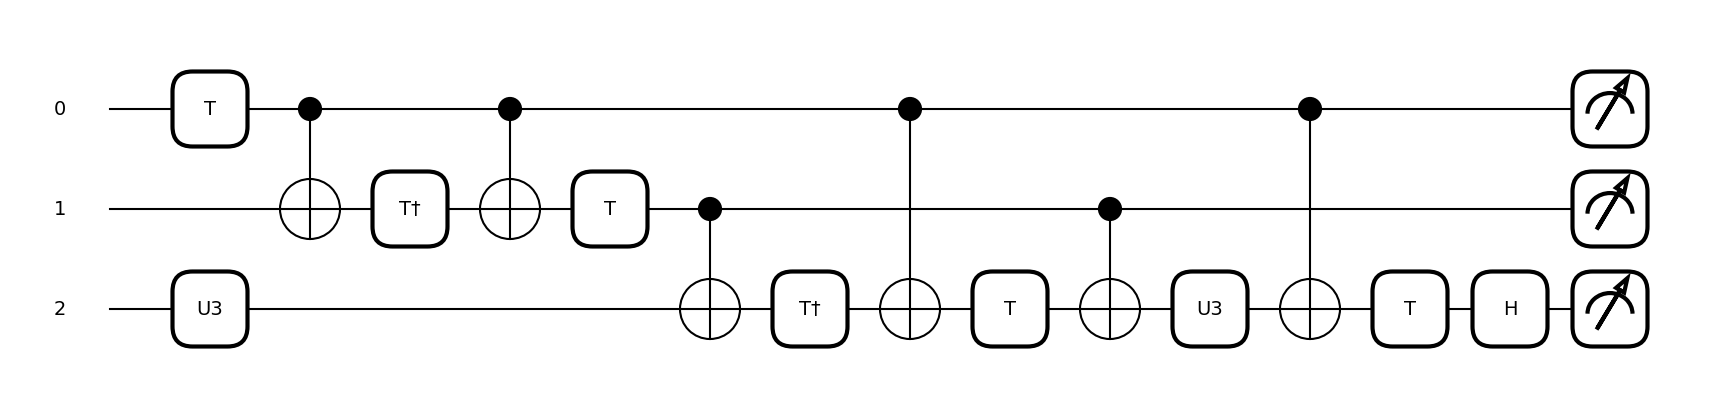

In [73]:
# Example usage of the custom gates in a new circuit
@qml.qnode(dev)
def test_toffoli(optimized_params):
    qml.T(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.adjoint(qml.T(wires=1))
    qml.CNOT(wires=[0, 1])
    qml.T(wires=1)
    CustomHadamard(wires=2)  # Use CustomGate1 with the first 3 optimized parameters
    qml.CNOT(wires=[1, 2])
    qml.adjoint(qml.T(wires=2))
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.CNOT(wires=[1, 2])
    CustomAdjointT(wires=2)  # Use CustomGate2 with the last 3 optimized parameters
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.Hadamard(wires=2)
    return [qml.expval(qml.PauliZ(wire)) for wire in range(3)]

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(test_toffoli)(optimized_params)

result = test_toffoli(optimized_params)
result

Y probamos que invertiendo los qubits de control, obtenemos la inversión en el qubit objetivo.

[tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-0.17381008, requires_grad=True)]

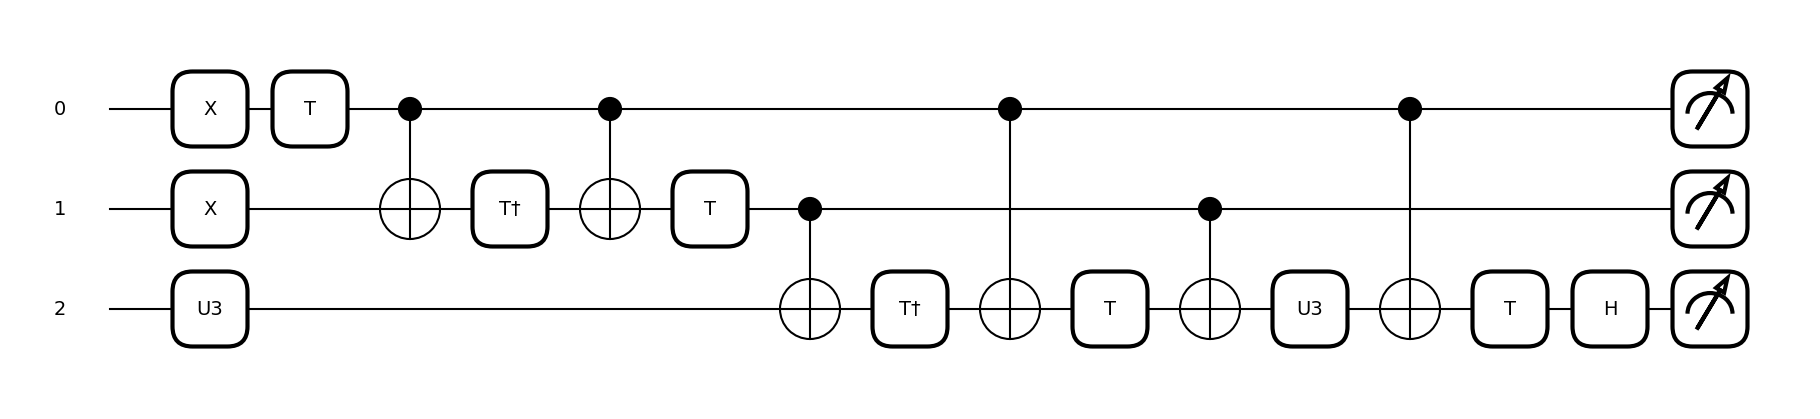

In [72]:
@qml.qnode(dev)
def test_toffoli(optimized_params):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.T(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.adjoint(qml.T(wires=1))
    qml.CNOT(wires=[0, 1])
    qml.T(wires=1)
    CustomHadamard(wires=2)  # Use CustomGate1 with the first 3 optimized parameters
    qml.CNOT(wires=[1, 2])
    qml.adjoint(qml.T(wires=2))
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.CNOT(wires=[1, 2])
    CustomAdjointT(wires=2)  # Use CustomGate2 with the last 3 optimized parameters
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.Hadamard(wires=2)
    return [qml.expval(qml.PauliZ(wire)) for wire in range(3)]

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(test_toffoli)(optimized_params)

result = test_toffoli(optimized_params)
result

Vemos que obtenemos los valores correctos, aunque con una fidelidad ligeramente menor a buscar los parámetros de todo el circuito.

Finalmente, comprobamos que las suposiciones de puertas son correctas:

[tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True),
 tensor(-1., requires_grad=True)]

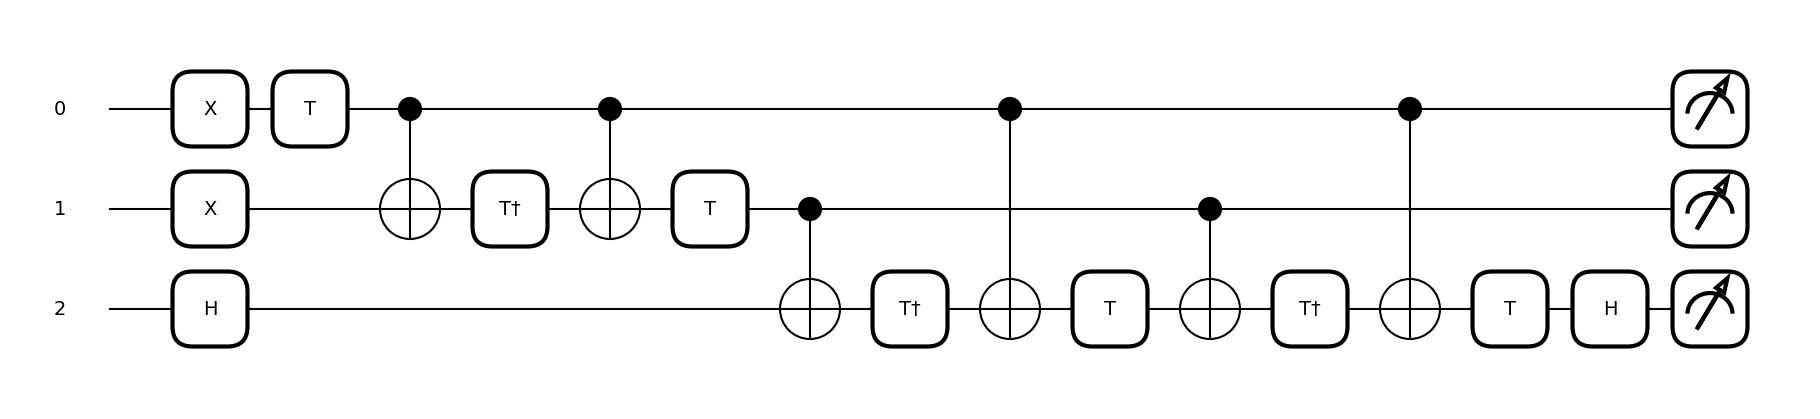

In [64]:
@qml.qnode(dev)
def toffoli():
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.T(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.adjoint(qml.T(wires=1))
    qml.CNOT(wires=[0, 1])
    qml.T(wires=1)
    qml.Hadamard(wires=2)
    qml.CNOT(wires=[1, 2])
    qml.adjoint(qml.T(wires=2))
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.CNOT(wires=[1, 2])
    qml.adjoint(qml.T(wires=2))
    qml.CNOT(wires=[0, 2])
    qml.T(wires=2)
    qml.Hadamard(wires=2)
    return [qml.expval(qml.PauliZ(wire)) for wire in range(3)]

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(toffoli)()

result = toffoli()
result